In [15]:
# Connecting to GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import os, glob, cv2
import numpy as np
%cd /content/gdrive/My Drive/assignment2/classify
from PIL import Image
from keras.utils import to_categorical

def load_image(filename, image_hw, augmentation=False):
    image = Image.open(filename)
    if augmentation:
        if np.random.rand() > 0.5:
            # 左右翻转
            image.transpose(Image.FLIP_LEFT_RIGHT)

    image = np.array(image)
    if len(image.shape) < 3:
        image = np.tile(np.expand_dims(image, -1), [1, 1, 3])
    elif image.shape[2] > 3:
        image = image[:, :, [0, 1, 2]]

    if image.shape[0] != image_hw[0] or image.shape[1] != image_hw[1]:
        image = cv2.resize(image, image_hw[::-1])
    return (image-127.5) / 127.5

class data_loader():

    def __init__(self, datadir, batch_size=8, image_hw=(256, 256)):

        self.n_class = 17
        self.batch_size = batch_size
        self.image_hw = image_hw

        txtfile = os.path.join(datadir, 'files.txt')
        with open(txtfile) as f:
            fs = f.readlines()
        fs = [os.path.join(datadir, f.split('\n')[0]) for f in fs]
        y = []
        for i in range(self.n_class):
            y.extend(80 * [i])
        N = len(fs)
        self.train_fs, self.test_fs, self.train_y, self.test_y = [], [], [], []
        for i in range(N):
            if i % 2 != 0:
                self.train_fs.append(fs[i])
                self.train_y.append(y[i])
            else:
                self.test_fs.append(fs[i])
                self.test_y.append(y[i])
        self.train_y = np.array(self.train_y)
        self.test_y = np.array(self.test_y)

    def data_generator(self, set='Train', aug=False):
        if set == 'train':
            fs, y = self.train_fs, self.train_y
        else:
            fs, y = self.test_fs, self.test_y

        N = len(fs)
        while True:
            idx = np.random.randint(0, N, self.batch_size)
            batch_X, batch_y = [], y[idx]
            for i in range(self.batch_size):
                id = int(idx[i])
                image = load_image(fs[id], self.image_hw, aug)
                batch_X.append(image)
            batch_X = np.array(batch_X)
            yield batch_X, to_categorical(batch_y, self.n_class)

/content/gdrive/My Drive/assignment2/classify


In [0]:
from tensorflow.contrib.keras import layers, models
from tensorflow.contrib.keras.api.keras.utils import get_file

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')

def VGG16(input_shape, classes=17):

    img_input = layers.Input(input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='relu_fc1')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu', name='relu_fc2')(x)
    x = layers.Dense(classes, activation='softmax', name='output')(x)

    model = models.Model(img_input, x, name='vgg16')

    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH,
                            cache_subdir='models', file_hash='64373286793e3c8b2b4e3219cbf3544b')
    model.load_weights(weights_path, by_name=True)

    return model

Epoch 1/20
100/100 [==============================] - 15s 147ms/step - loss: 2.8458 - acc: 0.0750

Epoch 00001: val_acc improved from -inf to 0.07500, saving model to ./models/vgg16.h5
 - 42s - loss: 3.0664 - acc: 0.0737 - val_loss: 2.8458 - val_acc: 0.0750
Epoch 2/20
100/100 [==============================] - 12s 119ms/step - loss: 2.7991 - acc: 0.0962

Epoch 00002: val_acc improved from 0.07500 to 0.09625, saving model to ./models/vgg16.h5
 - 43s - loss: 2.7884 - acc: 0.1213 - val_loss: 2.7991 - val_acc: 0.0962
Epoch 3/20
100/100 [==============================] - 10s 104ms/step - loss: 2.7428 - acc: 0.1275

Epoch 00003: val_acc improved from 0.09625 to 0.12750, saving model to ./models/vgg16.h5
 - 42s - loss: 2.6413 - acc: 0.1787 - val_loss: 2.7428 - val_acc: 0.1275
Epoch 4/20
100/100 [==============================] - 9s 85ms/step - loss: 2.5223 - acc: 0.1813

Epoch 00004: val_acc improved from 0.12750 to 0.18125, saving model to ./models/vgg16.h5
 - 39s - loss: 2.4191 - acc: 0.267

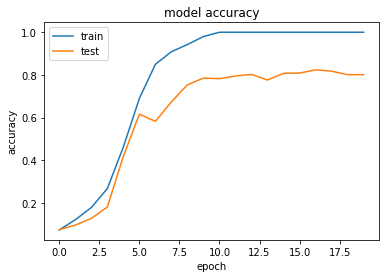

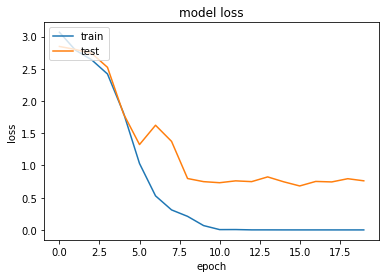

In [18]:
from tensorflow.contrib.keras import optimizers, losses, callbacks
from data_loader import *
from vgg16 import VGG16
import matplotlib.pyplot as plt

# Training parameters
batch_size = 8          # 每次迭代所用图片数
epochs = 20             # 训练轮数

datadir = './17flowers' # 训练数据目录
image_hw = (256, 256)   # 训练图像大小
n_class = 17

save_path = './models/vgg16.h5'

# Load dataset
dataLoader = data_loader(datadir, batch_size, image_hw)

# Build model.
model = VGG16(image_hw+(3,), n_class)
model.compile(optimizer=optimizers.SGD(lr=1e-2), loss=losses.categorical_crossentropy, metrics=['acc'])

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = callbacks.ModelCheckpoint(filepath=save_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
tensorboard = callbacks.TensorBoard('./models')
callbacks = [checkpoint, tensorboard, reduce_lr]

# Run training
history = model.fit_generator(dataLoader.data_generator('train'), steps_per_epoch=100,
                    validation_data=dataLoader.data_generator('val'), validation_steps=100,
                    epochs=epochs, verbose=2, callbacks=callbacks)

# Show training history
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acc.png')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

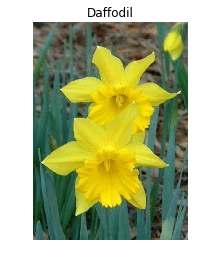

In [20]:
import matplotlib
from vgg16 import VGG16
import numpy as np
from data_loader import load_image
import matplotlib.pyplot as plt

filename = './17flowers/image_0003.jpg'

# Model parameters
image_hw = (256, 256)
save_path = './models/vgg16.h5'
class_name = ['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary'
              'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']
n_class = 17

# Build model.
model = VGG16(image_hw+(3,), n_class)
model.load_weights('./models/vgg16.h5')

# Classify
I = load_image(filename, image_hw)

# Show result
cls = model.predict(I[None])
cls = np.argmax(cls[0])
plt.imshow(plt.imread(filename))
plt.title(class_name[cls])
plt.axis('off')
plt.show()